In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,

)
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    LabelEncoder
)
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
)
from sklearn.metrics import mean_squared_error, r2_score
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv("/content/insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
n, m = data.shape
print(f"Number of columns: {m} columns\nNumber of rows: {n} rows")

Number of columns: 7 columns
Number of rows: 1338 rows


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [ ]:
styled_data = (
    data.describe()
    .drop("count", axis=0)
    .style.background_gradient(axis=0, cmap="magma")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([{"selector": "th", "props": [("background-color", "k")]}])
    .set_caption("Summary Statistics")
)

styled_data

,age,bmi,children,charges
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


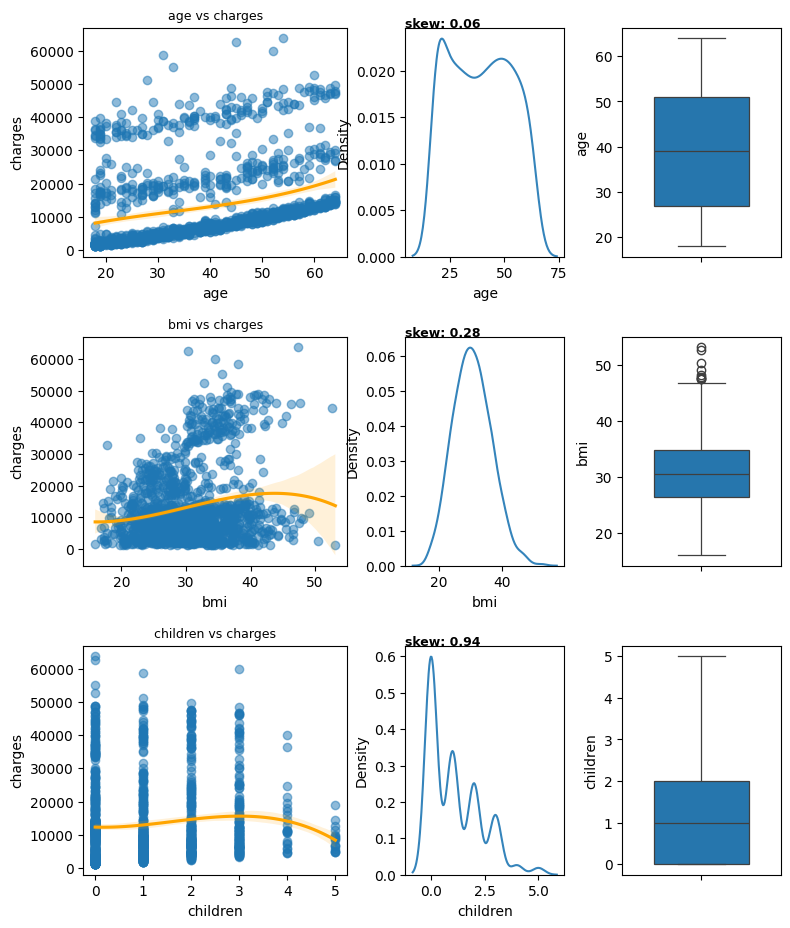

In [ ]:
number_columns = data.select_dtypes("number").drop("charges", axis=1)

skewness_before_log = data[number_columns.columns].skew()
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(9, 11),
    gridspec_kw={"hspace": 0.35, "wspace": 0.3, "width_ratios": [0.5, 0.3, 0.3]},
)
axes = axes.flatten()
i = 0
for column in number_columns.columns:
    ax = axes[i]
    sns.regplot(
        data=data,
        x=column,
        y="charges",
        ax=ax,
        scatter_kws={"alpha": 0.5},
        marker="o",
        line_kws={"color": "orange"},
        order=3,
    )
    ax.set_title(f"{column} vs charges", size=9)
    ax = axes[i + 1]
    sns.kdeplot(data=data, x=column, ax=ax, fill=False, alpha=0.9, legend=True)
    skewness = skewness_before_log[column]
    ax.text(
        ax.get_xlim()[0],
        ax.get_ylim()[-1],
        f"skew: {skewness:.2f}",
        size=9,
        weight="bold",
    )

    ax = axes[i + 2]
    sns.boxplot(
        data=data,
        y=column,
        ax=ax,
        width=0.6,
        saturation=0.9,
        linewidth=0.9,
    )
    i += 3

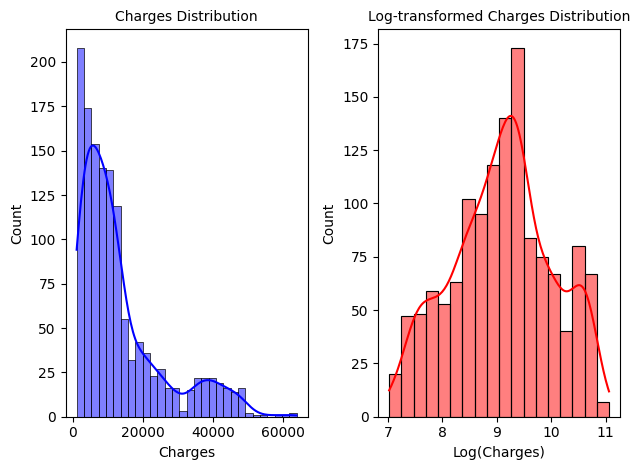

In [ ]:
fig = plt.figure()
plt.subplot(121)
sns.histplot(data['charges'], kde=True, color='blue')
plt.title('Charges Distribution', size=10)
plt.xlabel('Charges')

plt.subplot(122)
sns.histplot(np.log(data['charges']), kde=True, color='red')
plt.title('Log-transformed Charges Distribution', size=10)
plt.xlabel('Log(Charges)')
plt.tight_layout()
plt.show()

<Axes: >

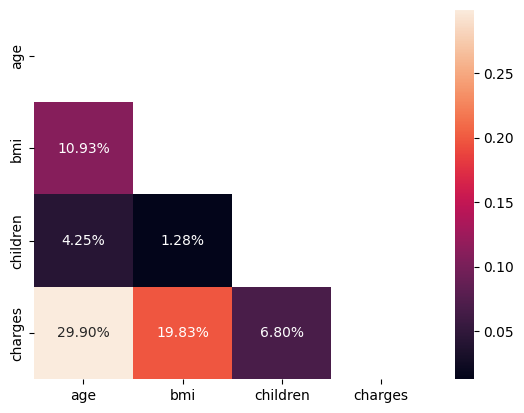

In [ ]:
corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2%")

In [ ]:
data["age group"] = pd.cut(data.age, bins=[0, 40, 60, 100], labels=["young adult", "middle-aged", "old adults"])

In [ ]:
data.groupby("age group")["charges"].agg(["mean", "count"])

,mean,count
age group,,
young adult,10219.422874,701
middle-aged,15888.757668,546
old adults,21063.163398,91


In [ ]:
data.groupby("smoker")["charges"].agg(["mean", "count"])

,mean,count
smoker,,
no,8434.268298,1064
yes,32050.231832,274


In [ ]:
from itertools import product
from collections import Counter

a = data["smoker"].unique().tolist()
b = data["age group"].unique().tolist()

labels = dict(zip(product(a, b, repeat=1), [4, 5, 6, 1, 2, 3]))


data["smoker_aged"] = data[["smoker", "age group"]].apply(lambda x: labels[tuple(x)], axis=1)

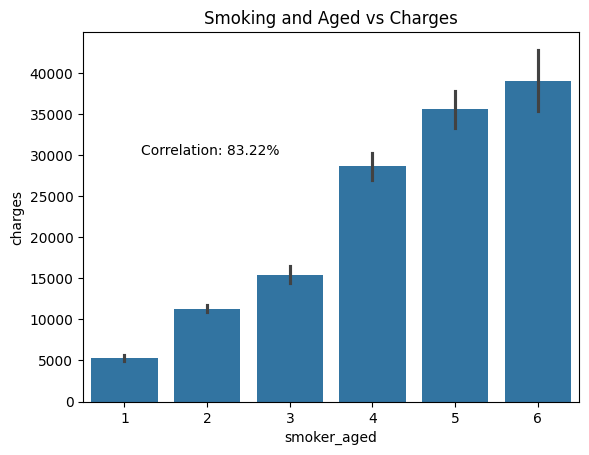

In [ ]:
sns.barplot(data=data, x="smoker_aged", y="charges")
correlation = data[["smoker_aged"]].corrwith(data.charges)[0]
plt.text(0.2, 30000, f"Correlation: {correlation:.2%}")
plt.title("Smoking and Aged vs Charges")
plt.show()

# 3. Linear Regression Models


In [ ]:
X = data.drop(['charges','region'], axis=1)
y = data.charges

X["sex"] = X["sex"].map({"female": 0, "male": 1})
X["smoker"] = X["smoker"].map({"no": 0, "yes": 1})
X["age group"] = X["age group"].map({"young adult": 0, "middle-aged": 1, "old adults": 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [ ]:
def model_pipeline(model, degree=2):
    num_pipeline = Pipeline(
        steps=[
            ("poly", PolynomialFeatures(degree=degree)),
            ("scaler", StandardScaler()),
        ]
    )


    transformer = ColumnTransformer([
        ("num_transformers", num_pipeline, make_column_selector(dtype_include="number"))
        ], remainder="passthrough")

    model_pipeline = Pipeline(steps=[("transformer", transformer), ("model", model)])
    return model_pipeline

In [ ]:
kf = KFold(shuffle=True, random_state=42, n_splits=3)

In [ ]:
# Gride Search for Linear Regression
lr = model_pipeline(LinearRegression())
lr_grid = {"transformer__num_transformers__poly__degree": range(0, 6)}

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=lr_grid,
    cv=kf,
    scoring=("r2", "neg_mean_squared_error"),
    refit="r2",
)
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(np.float64(0.8347203526468512),
 {'transformer__num_transformers__poly__degree': 2})

In [ ]:
best_lr = model_pipeline(
    LinearRegression(),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_lr.fit(X_train, y_train)
print("Training score", best_lr.score(X_train, y_train))
print("Testing score", best_lr.score(X_test, y_test))

Training score 0.8446550596341762
Testing score 0.8431179481438463


# Lasso Regression

In [ ]:
# Lasso regression
lasso = model_pipeline(Lasso())
lasso_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
}

grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(np.float64(0.8362952459910292),
 {'model__alpha': np.float64(4.832930238571752),
  'transformer__num_transformers__poly__degree': 2})

In [ ]:
best_l1 = model_pipeline(
    Lasso(alpha=grid_search.best_params_["model__alpha"]),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_l1.fit(X_train, y_train)
print("Training score", best_l1.score(X_train, y_train))
print("Testing score", best_l1.score(X_test, y_test))

Training score 0.844034684591997
Testing score 0.8437698574521892


# Ridge Regression

In [ ]:
# Ridge Regression
ridge = model_pipeline(Ridge())
ridge_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
}

grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(np.float64(0.8357422412902556),
 {'model__alpha': np.float64(0.5455594781168517),
  'transformer__num_transformers__poly__degree': 2})

In [ ]:
best_l2 = model_pipeline(
    Ridge(alpha=grid_search.best_params_["model__alpha"]),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_l2.fit(X_train, y_train)
print("Training score", best_l2.score(X_train, y_train))
print("Testing score", best_l2.score(X_test, y_test))

Training score 0.8441942314384716
Testing score 0.8426241271592876


# ElasticNet Regression

In [ ]:
# Elastic Net
elastic_net = model_pipeline(ElasticNet())
elastic_net_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
    "model__l1_ratio": np.linspace(0.01, 1, 10),
}


grid_search = GridSearchCV(estimator= elastic_net, param_grid=elastic_net_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(np.float64(0.8362952459910292),
 {'model__alpha': np.float64(4.832930238571752),
  'model__l1_ratio': np.float64(1.0),
  'transformer__num_transformers__poly__degree': 2})

In [ ]:
best_elastic_net = model_pipeline(ElasticNet(alpha=grid_search.best_params_["model__alpha"], l1_ratio=grid_search.best_params_["model__l1_ratio"]), degree=grid_search.best_params_["transformer__num_transformers__poly__degree"])
best_elastic_net.fit(X_train, y_train)
print("Training score", best_elastic_net.score(X_train, y_train))
print("Testing score", best_elastic_net.score(X_test, y_test))

Training score 0.844034684591997
Testing score 0.8437698574521892


# Models Evaluation

In [ ]:
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def compare_models(models, X, y):
    evaluate = {}

    for label, model in models.items():
        ypred = model.predict(X)

        score = round(r2_score(y, ypred) * 100, 2)
        loss = round(np.sqrt(mean_squared_error(y, ypred)), 2)

        evaluate[label] = [loss, score]

    return evaluate


In [ ]:
models = dict(lr = best_lr, lasso=best_l1, ridge=best_l2, elastic_net = best_elastic_net)

train_score_df = pd.DataFrame(compare_models(models, X_train, y_train), index=["rmse", "r2_score"]).T
test_score_df = pd.DataFrame(compare_models(models, X_test, y_test), index=["rmse", "r2_score"]).T

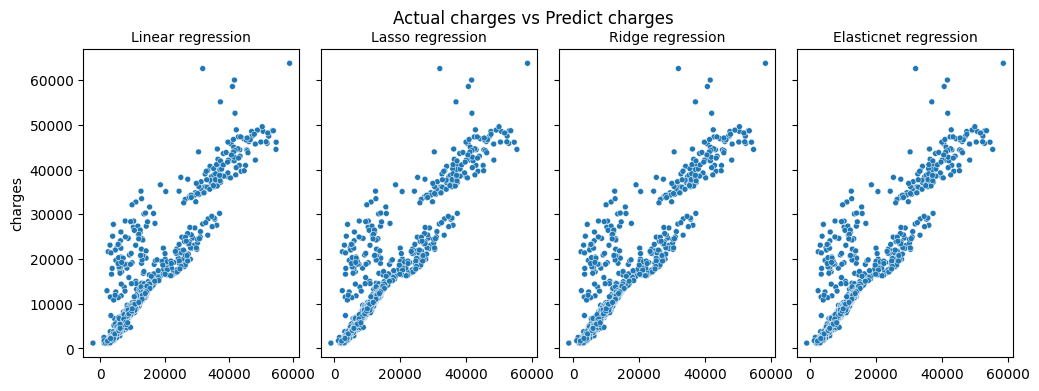

In [ ]:
def plot_actual_vs_pred(model, X, y, ax):
    ypred = model[-1].predict(X)
    sns.scatterplot(x=ypred, y=y, legend=False, ax=ax, size=3.5)
    ax.set_title(f"{model[0]}", size=10)


fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 4), gridspec_kw={"wspace": 0.1}, frameon=True)
plot_actual_vs_pred(("Linear regression", best_lr), X_train, y_train, ax=axes[0])
plot_actual_vs_pred(("Lasso regression", best_l1), X_train, y_train, ax=axes[1])
plot_actual_vs_pred(("Ridge regression", best_l2), X_train, y_train, ax=axes[2])
plot_actual_vs_pred(("Elasticnet regression", best_elastic_net), X_train, y_train, ax=axes[3])
fig.suptitle("Actual charges vs Predict charges")
plt.show()

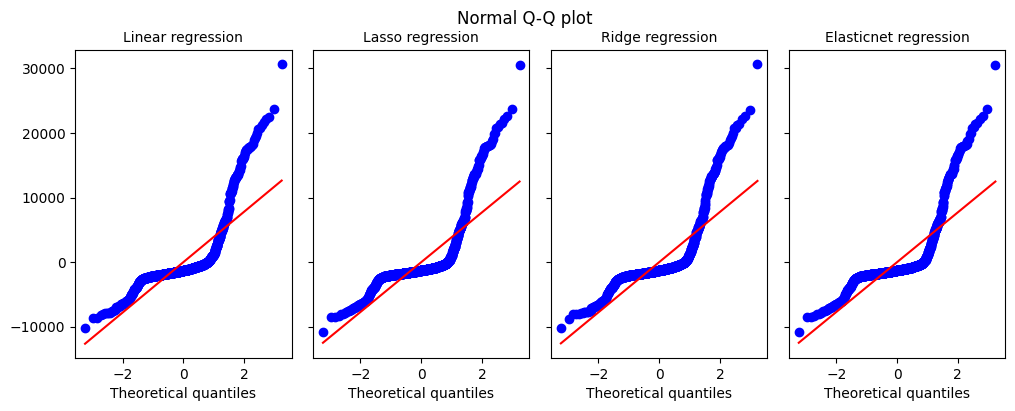

In [ ]:
from scipy.stats import probplot

def quantile_plot(model, X, y, ax):
    ypred = model[-1].predict(X)
    loss = y - ypred
    probplot(loss, dist="norm", plot=ax)
    ax.set_title(f"{model[0]}", size=10)
    ax.set_ylabel(ax.get_ylabel(), visible=False)


fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 4), gridspec_kw={"wspace": 0.1}, frameon=True)
quantile_plot(("Linear regression", best_lr), X_train, y_train, ax=axes[0])
quantile_plot(("Lasso regression", best_l1), X_train, y_train, ax=axes[1])
quantile_plot(("Ridge regression", best_l2), X_train, y_train, ax=axes[2])
quantile_plot(("Elasticnet regression", best_elastic_net), X_train, y_train, ax=axes[3])
fig.suptitle("Normal Q-Q plot")
plt.show()